## 1.1 データインポート

In [231]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as ticker
from collections import OrderedDict
%matplotlib inline

# データ読み込み(人材)
records_A =  pd.read_csv("train/train_A.tsv", delimiter='\t' )
train_A_df = pd.DataFrame(records_A)

# データ読み込み(旅行)
records_B =  pd.read_csv("train/train_B.tsv", delimiter='\t' )
train_B_df = pd.DataFrame(records_B)

# データ読み込み(不動産)
records_C =  pd.read_csv("train/train_C.tsv", delimiter='\t' )
train_C_df = pd.DataFrame(records_C)

# データ読み込み(アパレル)
records_D =  pd.read_csv("train/train_D.tsv", delimiter='\t' )
train_D_df = pd.DataFrame(records_D)

# やりたいこと：ユーザーに効果的なレコメンドをする

## 1.2 イベントタイプごとに集計する 

    人材、旅行、不動産、アパレルのデータについて、イベントタイプごとの集計をする

In [232]:
len(train_A_df[train_A_df["event_type"]==3]["product_id"].unique())

9235

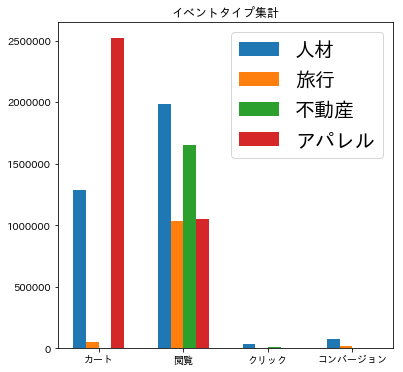

In [233]:
# イベントタイプごとの集計

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
x  = np.array([0, 1, 2, 3])
xC = np.array([1, 2, 3])
xD = np.array([0, 1, 3])
bar_width = 0.15
ax.bar(x,train_A_df.groupby("event_type")["user_id"].count(),width = bar_width, label = "人材", align = "center")
ax.bar(x + bar_width,train_B_df.groupby("event_type")["user_id"].count(),width = bar_width, label = "旅行", align = "center")
ax.bar(xC + bar_width*2,height = train_C_df.groupby("event_type")["user_id"].count(),width = bar_width, label = "不動産", align = "center")
ax.bar(xD + bar_width*3,train_D_df.groupby("event_type")["user_id"].count(),width = bar_width, label = "アパレル", align = "center")
ax.set_title('イベントタイプ集計')
ax.legend(fontsize=20)
plt.xticks(x+bar_width*1.5, ["カート","閲覧","クリック","コンバージョン"])

fig.show()

イベントタイプ集計から分かること…

人材：　カート38.1%、閲覧58.7%、クリック0.99%、コンバージョン2.20%。***コンバージョン率は最も高い、カートと閲覧のバランスが取れている***。
- 仮説：基本的には閲覧、カート、コンバージョンの流れができている？しかしカートとコンバージョンに差があるので難しい。
- 欲しい情報：ユーザーの行動履歴（どういう経緯でカートに入れる？コンバージョンに至る？）

旅行：　カート4.7%、閲覧93.0%、クリック0.3%、コンバージョン1.94%。***コンバージョン率は人材に次いで高い。閲覧に偏っている***。
- 仮説：カートとコンバージョンの差が小さい　→　カートに入れた段階でコンバージョンまでかなりの確率で持っていける？
- 欲しい情報：ユーザーの行動履歴（どういう経緯でカートに入れる？コンバージョンに至る？）

不動産：　<span style="color:red;">カート0%(0件)</span>、閲覧99%、クリック0.9%、コンバージョン0.08%。***ほぼ閲覧のみ、カートは0という特徴***。
- 仮説：この時点では立てづらいが、サイトにカートという機能が無いと思われる（閲覧ページから直接不動産屋に電話とかかな）？
- 欲しい情報：買われている商品の情報

アパレル：　カート70.6%、閲覧29.3%、<span style="color:red;">クリック0%(0件)</span>、コンバージョン0.02%。***他と比べ圧倒的にカートの割合が高い、クリックは0 という特徴***。
- 仮説１：クリック0%　→　そもそも広告を出していない？
- 仮説２：閲覧が少ないのにカートが異常に多い　→　閲覧(詳細ページ上の情報の取得)が効果薄い　→　一覧ページのサムネorブランドでカートへ直行？
- 欲しい情報：買われている商品の情報（ｎ回以上買われているものの割合など）

#### 総じて知りたいこと：買われている商品の情報、ユーザーの行動履歴
---

## 1.3 買われている商品の情報を調べる

    どういう商品が、どのような規模で買われているか？

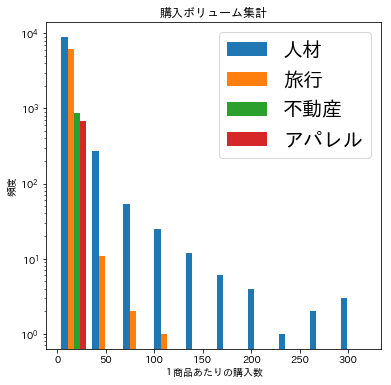

In [234]:
# 購入ボリュームの集計

conv_volume_series_A = train_A_df[train_A_df["event_type"]==3].groupby("product_id")["user_id"].count()
conv_volume_series_B = train_B_df[train_B_df["event_type"]==3].groupby("product_id")["user_id"].count()
conv_volume_series_C = train_C_df[train_C_df["event_type"]==3].groupby("product_id")["user_id"].count()
conv_volume_series_D = train_D_df[train_D_df["event_type"]==3].groupby("product_id")["user_id"].count()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.hist([conv_volume_series_A,conv_volume_series_B,conv_volume_series_C,conv_volume_series_D],label=['人材', '旅行', '不動産','アパレル'],bins=10)
# ax.hist(conv_volume_series_B,label='旅行',bins=30)
ax.set_title('購入ボリューム集計')
ax.set_yscale("log")
ax.set_xlabel("１商品あたりの購入数")
ax.set_ylabel("頻度")
ax.legend(fontsize=20)
fig.show()

上のように概形が出たが、たとえばアパレルは一本に潰されてしまっているので、ズームして見てみる。

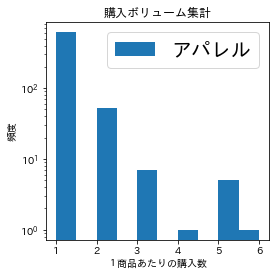

In [240]:
# アパレルの、購入ボリューム集計

conv_volume_series_D = train_D_df[train_D_df["event_type"]==3].groupby("product_id")["user_id"].count()
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.hist(conv_volume_series_D,label='アパレル',bins=10)
ax.set_title('購入ボリューム集計')
ax.set_yscale("log")
ax.set_xlabel("１商品あたりの購入数")
ax.set_ylabel("頻度")
ax.legend(fontsize=20)
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
fig.show()

アパレルは、１商品あたりの購入数のばらつきが比較的小さい、すなわちユーザーが購入する商品の偏りが少ないと言える<br>
ユーザーが購入する商品の偏りを、数値的に出してみる。

In [223]:
# 上位8割の売り上げ数を稼ぐ商品の割合
benchmark_ratio = 0.8

train_hoge_df_arr = OrderedDict()
train_hoge_df_arr['人材'] = train_A_df
train_hoge_df_arr['旅行'] = train_B_df
train_hoge_df_arr['不動産'] = train_C_df
train_hoge_df_arr['アパレル'] = train_D_df
committing_items_df = pd.DataFrame(index=["items_commiting","all","variance_rate"], columns=[])
for key,df in train_hoge_df_arr.items():
    conv_volume_series = df[df["event_type"]==3].groupby("product_id")["user_id"].count().sort_values(ascending=False)
    cumsum_conv_volume_series = conv_volume_series.cumsum()/conv_volume_series.sum()
    items_committing = cumsum_conv_volume_series[cumsum_conv_volume_series<benchmark_ratio].count()
    all = conv_volume_series.count()
    series = pd.Series([items_committing, all,items_committing/all],index=["items_commiting","all","variance_rate"])
    series = series.rename(key)
    committing_items_df = pd.concat([committing_items_df,round(series,2)], axis=1)

print("上位8割の売り上げ数を稼ぐ商品の割合")
committing_items_df

上位8割の売り上げ数を稼ぐ商品の割合


,人材,旅行,不動産,アパレル
items_commiting,3104.00,2902.00,590.00,530.00
all,9235.00,6218.00,862.00,687.00
variance_rate,0.34,0.47,0.68,0.77


上の表のvariance_rateの値が0.8に近ければ近いほど、ユーザーが購入する商品の偏りが少ないと言える。<br>
***ここで、人材と旅行は商品に偏りがあり、上半分の商品で売り上げ数の8割を占めている。***<br>
逆に、不動産とアパレルに関しては商品の偏りが少なく、満遍なく買われていることが分かる。

---

In [125]:
train_hoge_df_arr = OrderedDict()
train_hoge_df_arr['人材'] = train_A_df
train_hoge_df_arr['旅行'] = train_B_df
train_hoge_df_arr['不動産'] = train_C_df
train_hoge_df_arr['アパレル'] = train_D_df
from_ads_or_not_df = pd.DataFrame(index=[0,1], columns=[])
for key,df in train_hoge_df_arr.items():
#     print(key)
    series = df[df["event_type"]== 3].groupby("ad")["user_id"].count()/len(df[df["event_type"]== 3])*100
    series = series.rename(key)
    from_ads_or_not_df = pd.concat([from_ads_or_not_df,round(series,1)], axis=1)

print("コンバージョンが広告経由である割合")
from_ads_or_not_df.iloc[1]

コンバージョンが広告経由である割合


人材      47.0
旅行      62.0
不動産     37.6
アパレル    96.2
Name: 1, dtype: float64

*** ↑アパレル広告を掲載してなかったはずでは･･･？↑***

とりあえずそれは置いておいて、イベントタイプの集計に広告経由割合の特徴を追記すると･･･

> 人材：　カート38.1%、閲覧58.7%、クリック0.99%、<span style="color:red;">コンバージョン2.20%</span>。***コンバージョン率は最も高い、カートと閲覧のバランスが取れている***。
コンバージョンの約半分は広告経由。
    
> 旅行：　カート4.7%、<span style="color:red;">閲覧93.0%</span>、クリック0.3%、コンバージョン1.94%。***コンバージョン率は人材に次いで高い。閲覧に偏っている***。
コンバージョンの半分強は広告経由。

> 不動産：　<span style="color:red;">カート0%</span>、閲覧99%、クリック0.9%、コンバージョン0.08%。***ほぼ閲覧のみ、カートは0という特徴***。
コンバージョンの半分弱は広告経由。

> アパレル：　カート70.6%、閲覧29.3%、<span style="color:red;">クリック0%</span>、コンバージョン0.02%。***他と比べ圧倒的にカートの割合が高い、クリックは0 という特徴***。
コンバージョンのほぼすべてが広告経由。

もうひとつ気になる点があるとすると、

## 1.4 ユーザーの行動履歴を調べる

    どのようなアクションの末コンバージョンにたどり着いたか？

## 付録１

    ユーザーと商品IDでクロス集計。コンバージョンが３のものをカウント。

In [99]:
train_A_df = train_A_df[train_A_df['event_type']==3].head(100)

train_A_df

train_A_df.pivot_table(index=['user_id'], columns=['product_id'], values='event_type', fill_value=0, aggfunc='count')

product_id,00000051_a,00000224_a,00000430_a,00000530_a,00000602_a,00000759_a,00000871_a,00000982_a,00001017_a,00001054_a,...,00012913_a,00013154_a,00013170_a,00013204_a,00013419_a,00013460_a,00013631_a,00013640_a,00013738_a,00013965_a
user_id,,,,,,,,,,,,,,,,,,,,,
0000642_A,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
0001211_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0002428_A,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0002712_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0003440_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
0004396_A,0,1,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
0004560_A,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
0005027_A,0,0,2,0,0,1,3,0,1,0,...,0,1,1,1,1,1,0,0,0,0


## 付録２

    ユーザーの行動履歴ランキング

In [239]:
train_A_df.groupby(['user_id'])["product_id"].count().sort_values(ascending=False)

user_id
0025154_A    11987
0034199_A    10169
0012215_A     8532
0008926_A     6528
0029633_A     4377
0000720_A     3654
0037867_A     3283
0014249_A     2599
0050003_A     2582
0006490_A     2409
0025957_A     2327
0027948_A     2195
0010973_A     2164
0002467_A     2153
0006723_A     2071
0044616_A     2036
0006678_A     2014
0058477_A     2008
0044697_A     1999
0033835_A     1989
0046607_A     1982
0007927_A     1937
0014839_A     1924
0025900_A     1888
0028129_A     1866
0009511_A     1834
0009676_A     1815
0026355_A     1756
0007945_A     1681
0037618_A     1681
             ...  
0039509_A       10
0039510_A       10
0039511_A       10
0039513_A       10
0039514_A       10
0039515_A       10
0039517_A       10
0039468_A       10
0039466_A       10
0039418_A       10
0039436_A       10
0039423_A       10
0039426_A       10
0039427_A       10
0039429_A       10
0039430_A       10
0039431_A       10
0039432_A       10
0039435_A       10
0039441_A       10
0039460_A       10
0039